# EMA RSI Strategy

In [1]:
from datetime import datetime, timedelta
import logging

from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
import pandas as pd
from talib import ATR, EMA, RSI

from examples.data import (
    download_bars,
    separate_bars_by_symbol,
    split_multi_index_bars_train_test,
)

from bacta.backtester import EventBacktester, Order, Position
from bacta.utilities import dash
from bacta.utilities.logger import get_logger, set_log_level

set_log_level(logging.DEBUG)

/usr/local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class EmaStrategy(EventBacktester):
    """
    Backtester that uses the Keltner Channel to make decisions.
    """

    def __init__(self, active_symbols, cash, **kwargs):
        super().__init__(active_symbols, cash, **kwargs)
        self.short_ema_period = 21
        self.long_ema_period = 200
        self.rsi_period = 14

    def precompute_step(self, bars: pd.DataFrame):
        """
        Preload the indicators for the backtest.
        """

        split_bars = separate_bars_by_symbol(bars)

        self.short_emas = {
            symbol: EMA(
                split_bars[symbol].loc[:,
                                       "close"], timeperiod=self.short_ema_period
            )
            for symbol in self.active_symbols
        }
        self.long_emas = {
            symbol: EMA(
                split_bars[symbol].loc[:,
                                       "close"], timeperiod=self.long_ema_period
            )
            for symbol in self.active_symbols
        }
        self.rsis = {
            symbol: RSI(split_bars[symbol].loc[:, "close"],
                        timeperiod=self.rsi_period)
            for symbol in self.active_symbols
        }

    def update_step(self, bars: pd.DataFrame, index: pd.Timestamp):
        """
        Update the state of the backtester.
        """
        split_bars = separate_bars_by_symbol(bars)

        self.short_emas = {
            symbol: EMA(
                split_bars[symbol].loc[:,
                                       "close"], timeperiod=self.short_ema_period
            )
            for symbol in self.active_symbols
        }
        self.long_emas = {
            symbol: EMA(
                split_bars[symbol].loc[:,
                                       "close"], timeperiod=self.long_ema_period
            )
            for symbol in self.active_symbols
        }
        self.rsis = {
            symbol: RSI(split_bars[symbol].loc[:, "close"],
                        timeperiod=self.rsi_period)
            for symbol in self.active_symbols
        }

    def generate_orders(self, bar: pd.DataFrame, index: pd.Timestamp) -> list[Order]:
        """
        Make a decision based on the prices.
        """
        close_prices = bar.loc[:, "close"]
        # short ema is 21, long ema is 200
        # rsi is 14
        # if rsi is > 75 and short ema is > long ema, then short
        # if rsi is < 25 and short ema is < long ema, then long
        orders = []
        for symbol in self.active_symbols:
            quantity = round(400 / close_prices[symbol], 4)
            if (
                self.rsis[symbol][index] > 70
                and self.short_emas[symbol][index] > self.long_emas[symbol][index]
            ):
                orders.append(
                    Order(symbol, Position.SHORT,
                          close_prices[symbol], quantity)
                )
            elif (
                self.rsis[symbol][index] < 30
                and self.short_emas[symbol][index] < self.long_emas[symbol][index]
            ):
                orders.append(
                    Order(symbol, Position.LONG,
                          close_prices[symbol], quantity)
                )

        return orders


In [3]:
symbols = ["DTE", "DUK"]

bars = download_bars(
    symbols,
    start_date=datetime(2024, 1, 1),
    end_date=datetime(2025, 7, 31),
    timeframe=TimeFrame(1, TimeFrameUnit.Hour)
)
# split the bars into train and test
train_bars, test_bars = split_multi_index_bars_train_test(
    bars, split_ratio=0.8)

# create the backtester
backtester = EmaStrategy(
    symbols,
    cash=1000,
    allow_short=True,
    min_cash_balance=100,
    allow_overdraft=False,
    min_trade_value=1,
    market_hours_only=True,
    transaction_cost=0.000,
    transaction_cost_type="percentage",
)

# preload the train bars
backtester.load_train_bars(train_bars)

# run_backtest the backtest
backtester.run_backtest(test_bars)

# plot the order and state history
print(dash("order history"))
print(backtester.get_history())
print(dash("state history"))
print(backtester.get_state_history())

[2025-08-12 02:20:48][DEBUG] Loading data/DTEDUK_2024-01-01_2025-07-31_1Hour.pkl
[2025-08-12 02:20:48][DEBUG] Initializing backtester with active symbols: ['DTE', 'DUK'], cash: 1000, allow_short: True, allow_overdraft: False, min_cash_balance: 100, min_trade_value: 1, market_hours_only: True
[2025-08-12 02:20:48][INFO] Train bars have been previously loaded. Concatenating with test bars...
[2025-08-12 02:20:48][INFO] Running backtest over 16572 bars from 2025-04-06 18:00:00-04:00 to 2025-07-30 19:00:00-04:00...
[2025-08-12 02:20:48][DEBUG] Placing LONG 3.2579 DTE @ $122.780 (2025-04-09 10:00:00-04:00)
[2025-08-12 02:20:48][DEBUG] Placing LONG 3.5952 DUK @ $111.260 (2025-04-09 10:00:00-04:00)
[2025-08-12 02:20:48][DEBUG] Placing adjusted LONG 1.6216 DTE @ $123.330 (2025-04-09 11:00:00-04:00)
[2025-08-12 02:20:48][DEBUG] Skipping LONG 0.0 DUK @ $111.810 (not enough cash) (2025-04-09 11:00:00-04:00)


NotImplementedError: Overdraft for shortingis not implemented yet. Please set allow_overdraft to True.

In [ ]:
# plot the performance
print(dash("performance"))
print(backtester.pretty_format_performance())

- performance ------------------------------------------------------------------
Backtest Performance:
- Return on Investment: 12.30%
- vs. Buy and Hold Return: 3.15%
- Sharpe Ratio: 0.28
- Max Drawdown Percentage: 10.14%

- Start Portfolio Value: $10000.00
- End Portfolio Value: $11229.95
- Min Portfolio Value: $9749.85
- Max Portfolio Value: $11430.22
- Min Cash Balance: $8400.00
- Max Cash Balance: $35600.08
- Win Rate: 88.24%

- Number of Orders: 223
- Number of Winning Trades: 195
- Number of Losing Trades: 26
- Avg Trade Return: 2.54%
- Largest Win: 9.98% ($37.19)
- Largest Loss: -1.63% ($-5.99)
- Max Consecutive Wins: 7
- Max Consecutive Losses: 1

- Trading Period Start: 2025-04-06 18:00:00-04:00
- Trading Period End: 2025-07-30 16:00:00-04:00
- Trading Period Length: 114 days 22:00:00
- Time in Market: 97.61%


plotting...


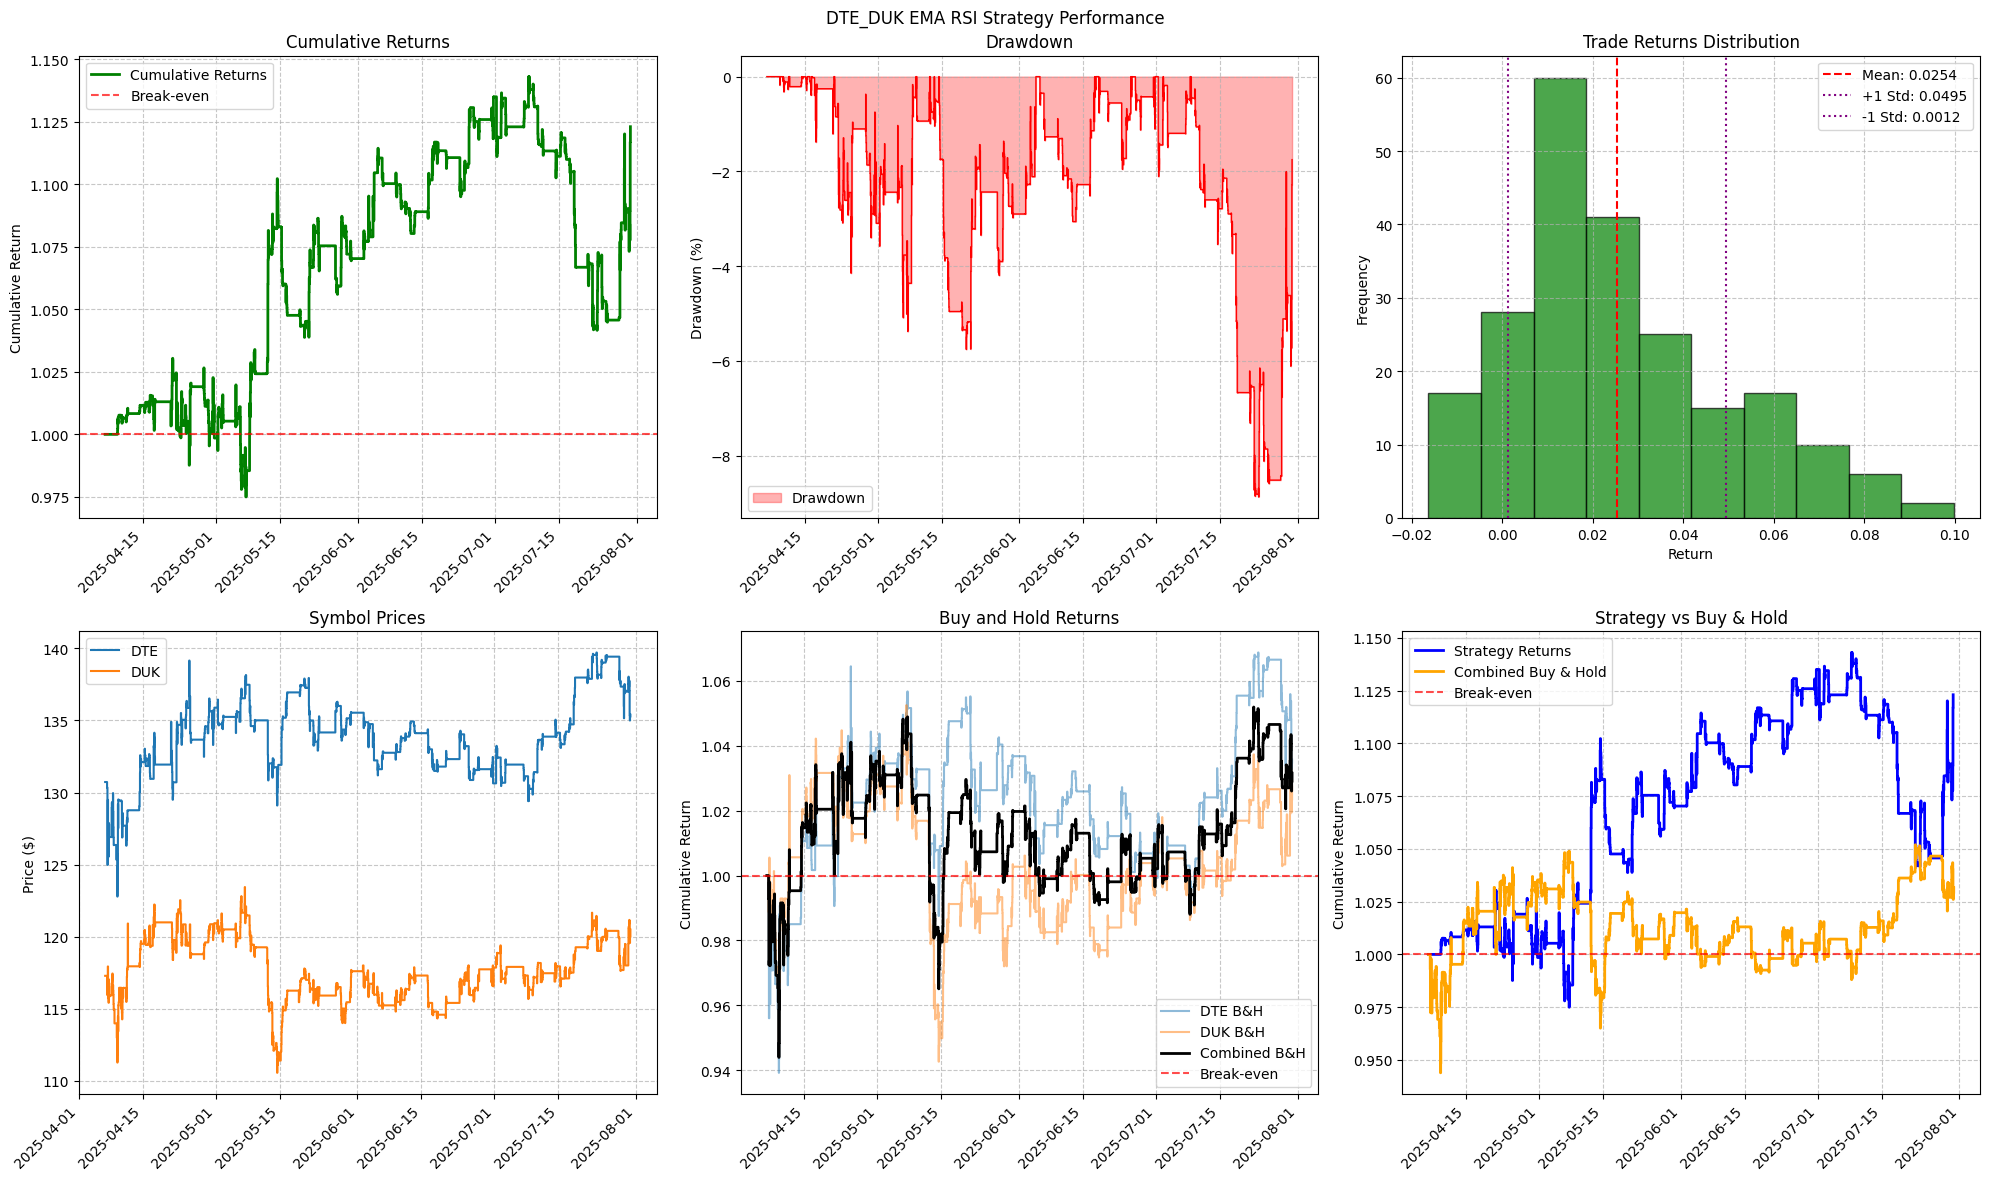

In [ ]:
# Plot the results
print("plotting...")
backtester.plot_performance_analysis(
    title="_".join(symbols) + " EMA RSI Strategy Performance", show_plot=False)

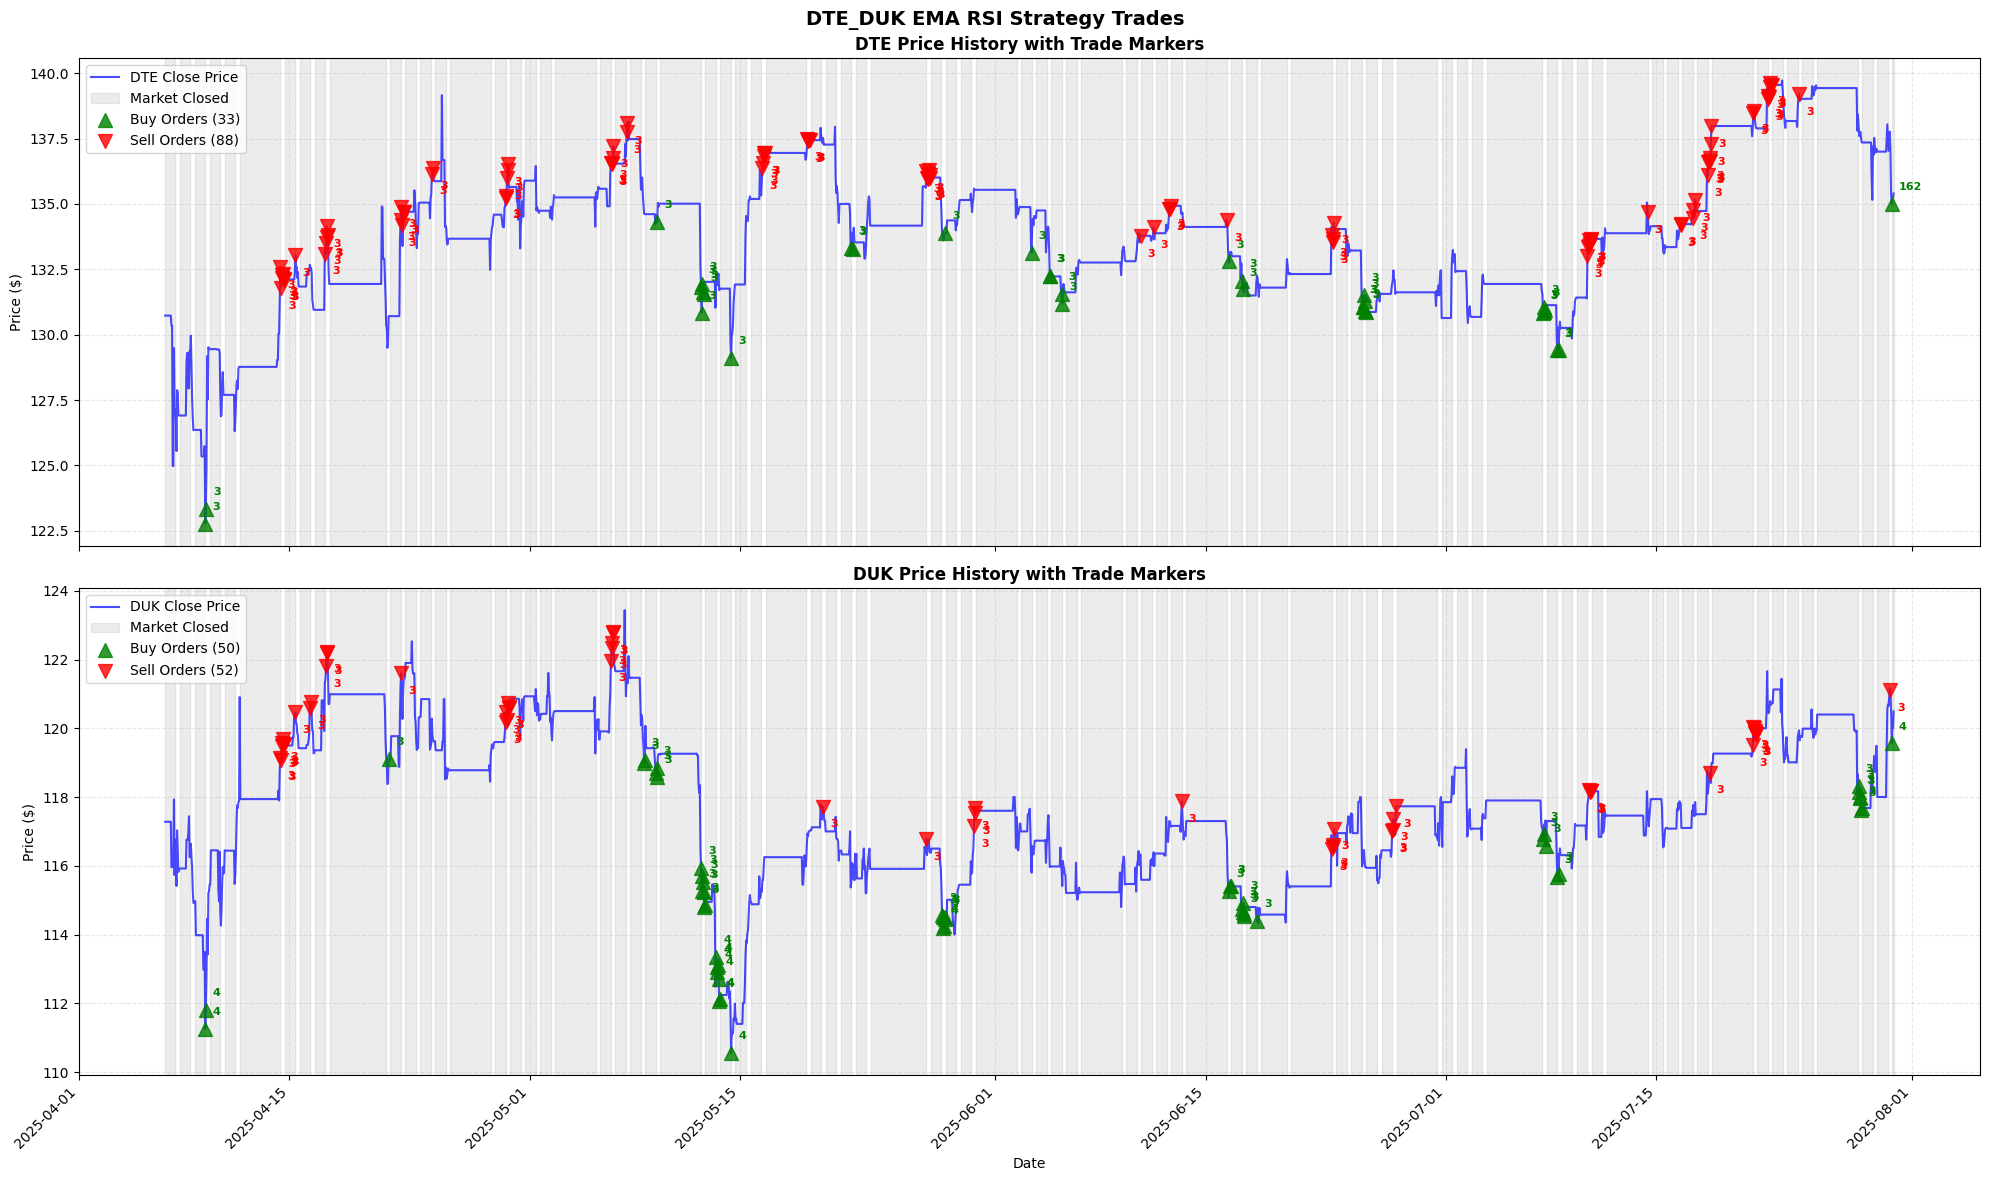

In [ ]:
backtester.plot_trade_history(title="_".join(
    symbols) + " EMA RSI Strategy Trades", show_plot=False)

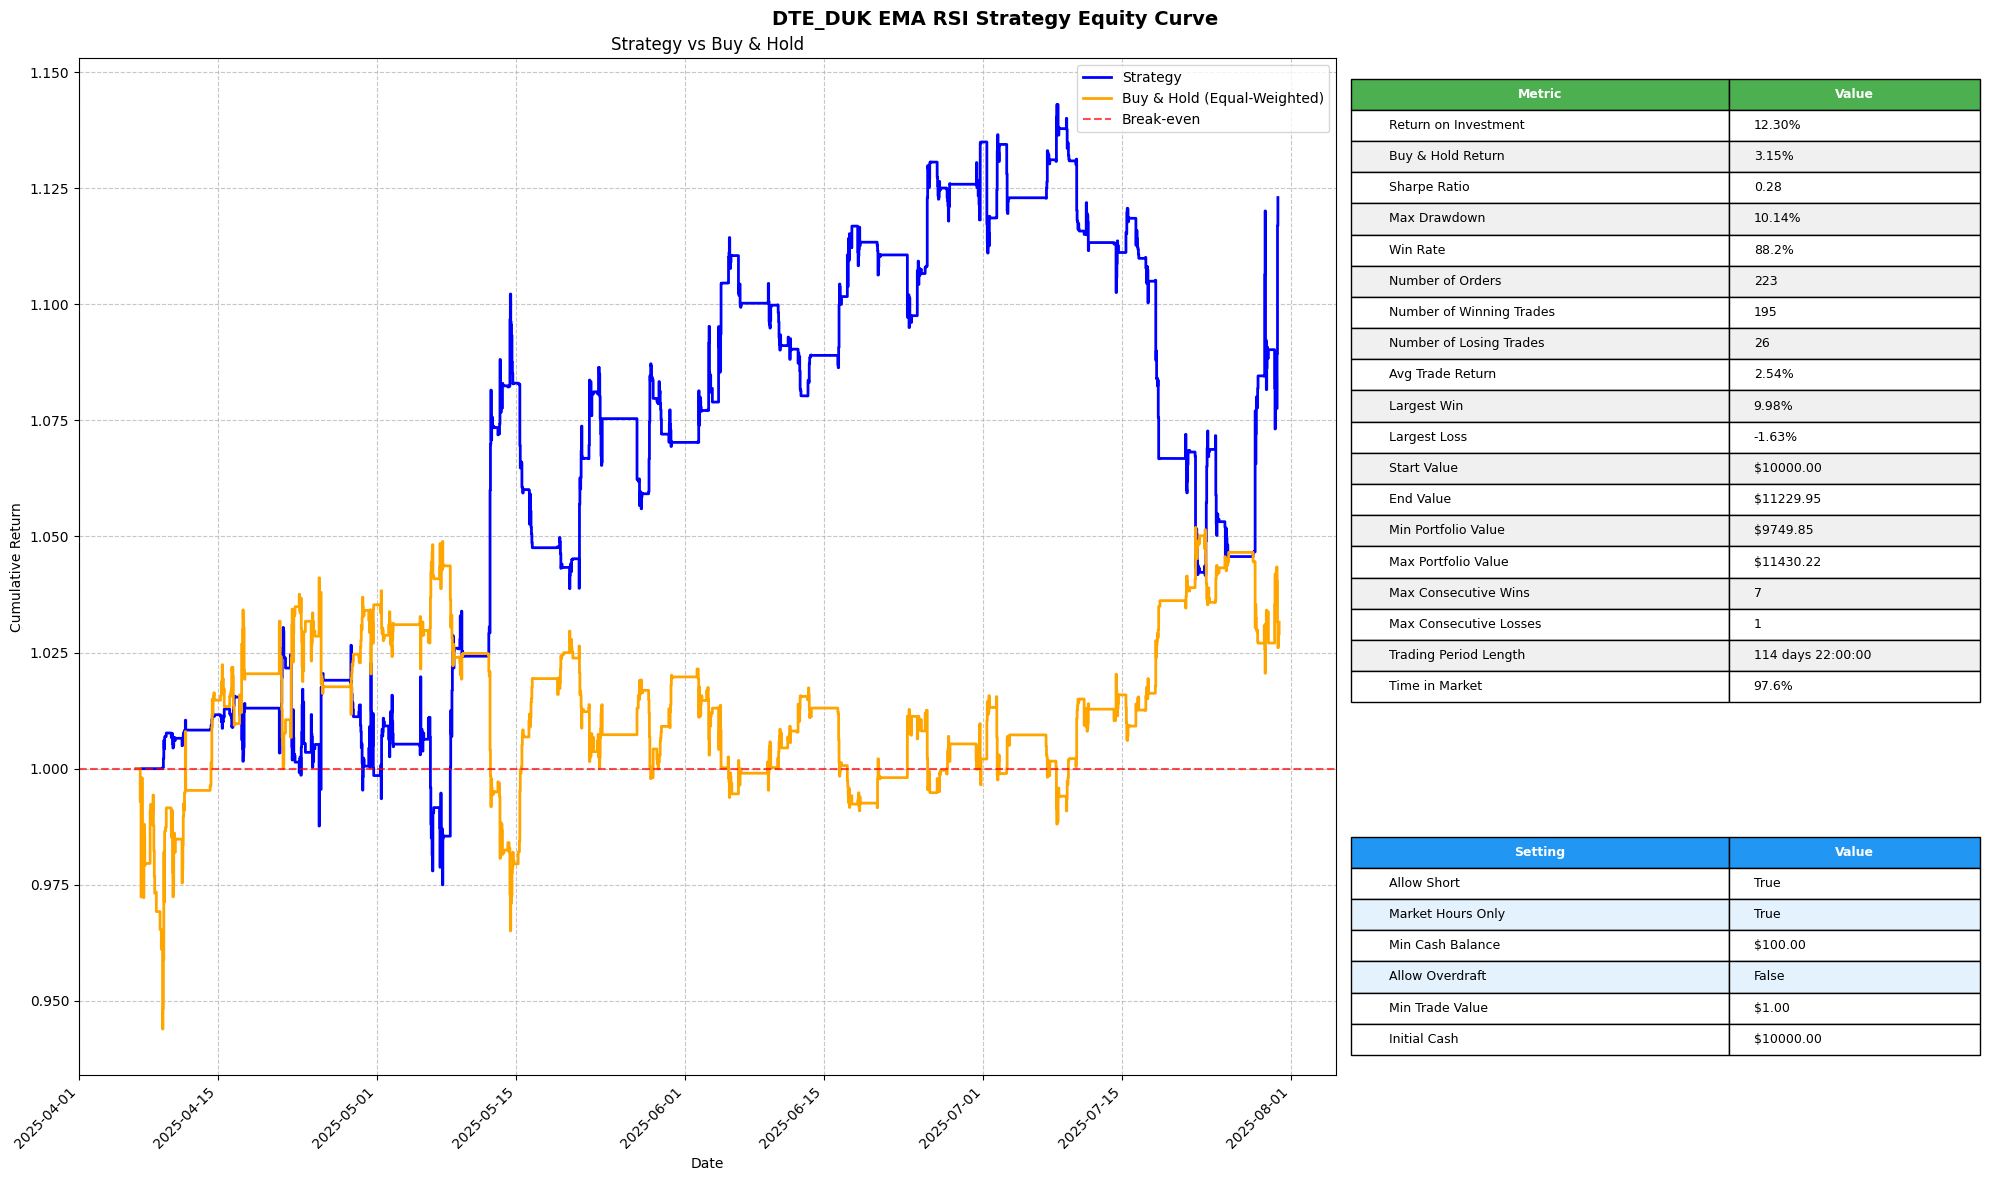

In [ ]:
backtester.plot_equity_curve(
    title="_".join(symbols) + " EMA RSI Strategy Equity Curve", show_plot=False
)